<a href="https://colab.research.google.com/github/virf96/Analisis_Texto/blob/master/Categorizacion_buenos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# librerias

In [3]:
pip install emot

In [4]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
from PIL import Image 
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import multiprocessing as mp
from multiprocessing import Pool
pd.options.display.max_colwidth = 200


Populating the interactive namespace from numpy and matplotlib


# funciones

In [5]:
# tokens
## palabras sin acentos ni puntuaciones
def remove_accented_chars(text):
  ##unicode.normalize para mandar a una sola codificación casos como la "n" y "ñ" en el idioma español
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8' , 'ignore')
    return text

## quita caracteres especiales
def remove_special_characters(text, remove_digits=True):
  ##Quitar caracteres que no esten dentro del abecedario a-z y A-Z
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern,' ', text)
    return text

## funcion lista a texto
def list_to_str(list):
    comm = ''
    for words in list: 
        comm = comm + words + ' '
    comm=comm.strip()
    return(comm)

## funcion texto a token por oracion
def tokenize_text(text):
  ##con "nltk.sent_tokenize" tokenizas la cada oración del texto   ¿Es necesario este paso?
    sentences = nltk.sent_tokenize(text)
    ##Una vez identificado el comienza y el fin de las oraciones procedemos a hacer split sobre cada palabra de las oraciones
    word_tokens = [nltk.word_tokenize(sentences) for sentences in sentences]  
    return word_tokens

## funcion que obtiene tokeniza los comentarios
def comments(df):
    split_com=[]
    #Función que recibe la columna de un data frame en donde esten los comentarios y los tokeniza
    split_com = [x.split(" ") for x in df['Comentario'].astype(str)]
    return(split_com)

## funcion que obtiene las palabras de los comentarios
def list_to_words(comments):
    lista = []
    for x in comments:
        lista.extend(x)
        #Función que devuelve las palabras existentes en una oración
    return(lista)

## limpia lista de palabras 

## palabras en minuscula sin acentos, caracteres especiales, stopwords
def clean_word(palabras):
  #Función que utiliza una función ya definida para llevar la oración a minuscula y sin caracteres especiales
    lista=[remove_accented_chars(x.lower()) for x in palabras]  ##lista
    lista=list_to_str(lista) ##string
    #¿Porque se le hace un segundo proceso de limpieza al texto?
    lista2=remove_special_characters(lista)  ##string
    word_tokens = nltk.word_tokenize(lista2)
    #Guardamos todas las palabras de parada que no esten incluidas en "stopwords.words('spanish')"
    lista=[x for x in word_tokens if x not in stopwords.words('spanish')]
    return(lista)

## palabras de comentarios en minuscula sin acentos, caracteres especiales, stopwords
stop1=['enero','ene','febrero', 'feb','marzo', 'abril','mayo','junio','agosto','septiembre','octubre','noviembre','dic','diciembre','a',
       'am','ademas','al','algo', 'alguien','algun','alguna','algunas','algunos', 'alguno','alla','alli','ahi','ante','antes','aqui','aquellas','aquello',
       'asi', 'atras','ay',
       'ayer', 'casi','como','con','contra', 'cual', 'cuando', 'de','del','desde','demas','donde','durante','e','el','ella','ellas','ello','ellos',
       'en','entre','esa','esas','ese','eso','esos','esta','estas','este','esto','estos','etc','hasta','hay','la','las','le','les','lo','los','mas','me',
       'mi','mia', 'mias','mio','mios', 'mis','mucho','muchos','muy','nos','nosotras', 'nosotros', 'nuestra', 'nuestras','nuestro','nuestros',
       'o','os','otra', 'otras','otro', 'otros','pm', 'para','pero','poco','por','porque','pues','que','quien','quienes','se','si','sin','sobre','su',
       'sus','suya','suyas','suyo','suyos','tambien', 'tanto','te','ti','tu','tus','tuya','tuyas','tuyo','tuyos','un','una','uno','unos','vosotras',
       'vosotros','vuestra','vuestras','vuestro', 'vuestros', 'y','ya','yo']

def clean_com(comments):
    aux=[]
    for x in range(0,len(comments)):
      #Regresa el comentario sin caracteres especiales y sin palabrabras de parada ya identificadas en "stop1" 
        aux.append([y for y in nltk.word_tokenize(remove_special_characters(comments[x]).strip()) if y not in stop1] )
    return(aux)


#    text = re.sub('\[.*?¿\]\%', ' ', text)
 #   text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  #  text = re.sub('\w*\d\w*', '', text)

def replaceAccents(word):
        word = word.replace('í','i')
        word = word.replace('ó','o')
        word = word.replace('ò','o')
        word = word.replace('ñ','n')
        word = word.replace('é','e')
        word = word.replace('è','e')
        word = word.replace('á','a')
        word = word.replace('à','a')
        word = word.replace('ü','u')
        word = word.replace('ú','u')
        word = word.replace('ö','o')
        word = word.replace('ë','e')
        word = word.replace('ï','i')
        return word

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Cargamos Corpus

In [7]:
# corrector
from collections import Counter

### texto en minisculas
def words(text): 
    return re.findall(r'\w+', text.lower())

## carga de diccionario, viene sin acentos la fuente
#WORDS = Counter(words(open('C:/Users/FerDL/Documents/6 Trabajo/Google Customer Reviews/2 Codigos/corpus_es.txt').read()))
#WORDS = Counter(words(open('C:/Users/cenic/Documents/1 Proyectos/Google Customer Reviews/2 Codigos/corpus_es.txt').read()))
WORDS = Counter(words(open('/content/drive/My Drive/datasets/corpus_es.txt').read()))


In [8]:
WORDS

Counter({'abasolo': 1,
         'acomodada': 1,
         'acomodado': 1,
         'acomodo': 1,
         'acosadores': 1,
         'afore': 1,
         'afuera': 20,
         'agilizan': 1,
         'ahorita': 1,
         'altamira': 1,
         'amontonado': 1,
         'andaba': 1,
         'antireflejante': 1,
         'aparcar': 1,
         'arreglaron': 1,
         'arriesgues': 1,
         'asaltan': 1,
         'atenderte': 1,
         'aurrera': 1,
         'hay': 6349,
         'ayudarme': 1,
         'ayudarte': 1,
         'batalle': 1,
         'bbb': 1,
         'bici': 1,
         'bocinas': 1,
         'bonita': 1,
         'bonitas': 1,
         'bonito': 1,
         'buscaba': 19,
         'buscas': 1,
         'cajuela': 1,
         'careros': 1,
         'centrica': 1,
         'chafa': 1,
         'chavo': 1,
         'chido': 1,
         'chip': 1,
         'chiste': 1,
         'colgador': 1,
         'comprarle': 1,
         'compras': 170,
         'comprelo': 1

In [9]:

#Función para dar la probailidad de aparición de la palabra en el CORPUS
def P(word): 
    N=0
    for a in WORDS:
        N=N+WORDS[a]
    "Probability of `word`."
    return WORDS[word] / N


def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits1(word):
    "All edits that are one edit away from `word`."
    alphabet    = 'abcdefghijklmnopqrstuvwxyz'
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known(edits0(word)) or known(edits1(word)) or known(edits2(word)) or [word])

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correction(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)


In [10]:
### separar palabras ej cara,gato en cara , gato
def comas2(sentence):
    c=[]
    for word in sentence:
        if word[0]==",":
            word=word[1:]
            continue
        
        a=re.split(',', word)
        c.extend(a)
    sentence=c
    return(sentence)

## separa palabras juntas 
def split_words(lista_principal, lista_separa):
    vocal=["a","e","i","o","u"]
    tres_letras=["aer","air", "ais","aun", "aut","aud","aul", "aur","aug","aum", "aus","aux","eol","eur","euf","euc","oax","oes",
                                             "oia","oir","oid","oig","oib","oim","ois","out","ueb"]
    lista1=lista_principal
    for item in lista_separa:
        lista2=[]
        for word in lista1:
            if word.find(item)==-1:             ### no encuentra la palabra a separar en la palabra en el comentario
                lista2.append(word)
                continue
            elif word[0:len(item)]==word:   ### la palabra a buscar es la misma que la palabra en el comentario
                lista2.append(word)
                continue
                
            elif item[-1]  in vocal and item==word[:len(item)]:   ### la palabra a buscar termina en vocal 
                word1=word[0:len(item)]
                word2=word[len(item):]
                if len(word2)==1:
                    if word2 in ['r','s', 'n', 'd']:
                        lista2.append(word)
                    else:
                        lista2.append(word1)
                    continue
                elif not word2[0] in vocal and word2[1] in vocal: 
                    lista2.append(word1)
                    lista2.append(word2)
                    continue
                elif word2[0] in vocal:
                    lista2.append(word1)
                    lista2.append(word2)
                    continue
                else:
                    lista2.append(word)
                    continue
                    
            elif not item[-1]  in vocal and item==word[:len(item)]:
                word1=word[0:len(item)]
                word2=word[len(item):]
                if item in ["buen", "mejor"] and word in ["buenas", "mejorar"]:
                    lista2.append(word)
                    continue
                elif len(word2)==1:
                    if word2 in vocal:
                        lista2.append(word)
                    else:
                        lista2.append(word1)
                    continue                
                elif not word2[0] in vocal and word2[1] in vocal: 
                    lista2.append(word1)
                    lista2.append(word2)
                    continue
                elif word2[0] in vocal and word2[0:3] in tres_letras:
                    lista2.append(word1)
                    lista2.append(word2)
                    continue
                elif word2[0] in vocal and not word2[1] in vocal:
                    lista2.append(word1)
                    lista2.append(word2)
                    continue
                else: 
                    lista2.append(word)
                    continue
            else:
                lista2.append(word)
        lista1=lista2
    return lista1

#lista_separa2=[]
lista_separa=["articulo", "atencion", "atienden", "banco", "bien", "buen", "bueno", "cajas", "caro", "cliente",
              "comprar", "coppel", "cosa", "credito", "empleados", "estacionamiento", "estan", "falta", "gente", "hacer", "lento", "lugar", "malo",
              "mejor", "mucho", "nada", "pagar", "pago", "pequeno", "persona", "personal", "pesimo", "precio", "ropa", "servicio", "siempre", "solo", "surtido",
              "tienda", "tiene", "tienen", "todo", "variedad"]

##Lematización

In [11]:
# lematizacion
#encoding: utf8
lemmaDict = {}
#with open('C:/Users/FerDL/Documents/6 Trabajo/Google Customer Reviews/2 Codigos/lemmatization-es.txt', 'rb') as f:
#with open('C:/Users/cenic/Documents/1 Proyectos/Google Customer Reviews/2 Codigos/lemmatization-es.txt', 'rb') as f:
with open('/content/drive/My Drive/datasets/lemmatization-es.txt', 'rb') as f:
    data = f.read().decode('utf8').replace(u'\r', u'').split(u'\n')
    data = [a.split(u'\t') for a in data]


In [12]:
data

[['\ufeff1', 'primer'],
 ['1', 'primera'],
 ['1', 'primeras'],
 ['1', 'primero'],
 ['1', 'primeros'],
 ['10', 'décima'],
 ['10', 'décimas'],
 ['10', 'décimo'],
 ['10', 'décimos'],
 ['100', 'centésima'],
 ['100', 'centésimas'],
 ['100', 'centésimo'],
 ['100', 'centésimos'],
 ['1000', 'milésima'],
 ['1000', 'milésimas'],
 ['1000', 'milésimo'],
 ['1000', 'milésimos'],
 ['10000', 'diezmilésima'],
 ['10000', 'diezmilésimas'],
 ['10000', 'diezmilésimo'],
 ['10000', 'diezmilésimos'],
 ['100000', 'cienmilésima'],
 ['100000', 'cienmilésimas'],
 ['100000', 'cienmilésimo'],
 ['100000', 'cienmilésimos'],
 ['1000000', 'millonésima'],
 ['1000000', 'millonésimas'],
 ['1000000', 'millonésimo'],
 ['1000000', 'millonésimos'],
 ['10000000', 'diezmillonésima'],
 ['10000000', 'diezmillonésimas'],
 ['10000000', 'diezmillonésimo'],
 ['10000000', 'diezmillonésimos'],
 ['100000000', 'cienmillonésima'],
 ['100000000', 'cienmillonésimas'],
 ['100000000', 'cienmillonésimo'],
 ['100000000', 'cienmillonésimos'],
 [

In [13]:

#minusculas=[]
#for i in prueba:
 #   minusculas.append([remove_accented_chars(i[1]), remove_accented_chars(i[0])])
    
for a in data:
    if len(a) >1:
        lemmaDict[remove_accented_chars(a[1])] = remove_accented_chars(a[0])

def lemmatize(word):
    return lemmaDict.get(word, word)

def lematiza_lista(texto):
    split_com=[]
    for sentence in texto:
        split_com.append([lemmatize(word) for word in sentence])
    #texto=split_com
    return(split_com)

In [14]:
# Function for converting emojis into word
def convert_emojis(text):
    ponctuation = list("[.,]()")
    for emot in UNICODE_EMO:
#        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(","," ").replace(":"," ").split()))
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].split())).replace("::"," ")
    if text[0]==":":
        text=text[1:]
    if text[-1]==":":
        text=text[:len(text)-1]
    text=" ".join(text.split(":")).strip()
    text=text.replace(" .",".").replace(" ,",",")
    return text

## limpia el translate de los comentarios
def limpia_translate(lista):
    aux=[]
    for x in lista:
        if x.find("(translated by google)")==-1:
            aux.append(x)
        elif x[0:22]=="(translated by google)":
            aux.append(x[x.find("(original)")+10:].strip())
        else:
            aux.append(x[:x.find("(translated by google)")].strip())
    return(aux)

## diccionario de verbos


In [15]:
#pathConjug = "C:\\Users\\FerDL\\Documents\\6 Trabajo\\Moderador\\senti_py_master\\classifier\\data\\dictConjug.json" ## XXX : to fill
#pathConjug = "G:\\Mi unidad\\HomeOffice\\Google Customer Reviews (todos)\\dictConjug.json" ## XXX : to fill
pathConjug = "/content/drive/My Drive/datasets/dictConjug.json" ## XXX : to fill
with open(pathConjug, 'r') as f:
    dictConjug = json.load(f)

ponctuation = list("[.,:;!?]()")


In [40]:
dictConjug

{'abonar': ['abonas',
  'abona',
  'abonamos',
  'abonais',
  'abonan',
  'he_abonado',
  'has_abonado',
  'ha_abonado',
  'hemos_abonado',
  'habeis_abonado',
  'han_abonado',
  'abonaba',
  'abonabas',
  'abonaba',
  'abonabamos',
  'abonabais',
  'abonaban',
  'habia_abonado',
  'habias_abonado',
  'habia_abonado',
  'habiamos_abonado',
  'habiais_abonado',
  'habian_abonado',
  'abone',
  'abonaste',
  'abonamos',
  'abonasteis',
  'abonaron',
  'hube_abonado',
  'hubiste_abonado',
  'hubo_abonado',
  'hubimos_abonado',
  'hubisteis_abonado',
  'hubieron_abonado',
  'abonare',
  'abonaras',
  'abonara',
  'abonaremos',
  'abonareis',
  'abonaran',
  'habre_abonado',
  'habras_abonado',
  'habra_abonado',
  'habremos_abonado',
  'habreis_abonado',
  'habran_abonado',
  'abonaria',
  'abonarias',
  'abonaria',
  'abonariamos',
  'abonariais',
  'abonarian',
  'habria_abonado',
  'habrias_abonado',
  'habria_abonado',
  'habriamos_abonado',
  'habriais_abonado',
  'habrian_abonado',
 

In [17]:
## verbos en infinitivo
def replaceVerbs(x):
    if len(x)==0:
        x = x
    else:
        addBack = False
        if x[-1] in ponctuation:
            endPonctu = x[-1]
            addBack = True
            x = x[:-1]
        for infinitif in dictConjug.keys():            ## busca en cada verbo
            foundMatch = any(e in x.replace(' ','*') for e in set(dictConjug[infinitif]))    ## busca las conjugaciones
            if foundMatch==False:
                pass
            else:
                x = x.replace(' ','*')
                matches = [e for e in set(dictConjug[infinitif]) if '*'+e+'*' in x] ## reemplaza por el infinitivo
                for e in matches:
                    x = x.replace('*'+e+'*','*'+infinitif+'*')
                del matches
                if x.split('*')[0] in set(dictConjug[infinitif]):
                    x = x.replace(x.split('*')[0]+'*'+x.split('*')[1]+'*'+x.split('*')[2],infinitif+'*'+x.split('*')[1]+'*'+x.split('*')[2])
                if '*'.join(x.split('*')[:2]) in set(dictConjug[infinitif]):
                    x = x.replace('*'.join(x.split('*')[:2])+'*'+x.split('*')[2]+'*'+x.split('*')[3],infinitif+'*'+x.split('*')[2]+'*'+x.split('*')[3])
                if x.split('*')[-1] in set(dictConjug[infinitif]):
                    x = x.replace(x.split('*')[-3]+'*'+x.split('*')[-2]+'*'+x.split('*')[-1],x.split('*')[-3]+'*'+x.split('*')[-2]+'*'+infinitif)
                if '*'.join(x.split('*')[-2:]) in set(dictConjug[infinitif]):
                    x = x.replace(x.split('*')[-4]+'*'+x.split('*')[-3]+'*'+'*'.join(x.split('*')[-2:]),x.split('*')[-4]+'*'+x.split('*')[-3]+'*'+infinitif)
                x = x.replace('*',' ')
        if addBack:
            x = x + endPonctu
        return x

In [18]:
#Diccionario de palabras para llevar a la forma base otras palabras es decir LEMATIZAR
dict_palabras = {
    "abono": ["abonos"],
    "abandonado": ["abandonadas","abandonada","abandonados"],
    "abierto": ["abierta","abiertas", "abiertos"],
    "accesible": ["accesble","accesibled", "accesibles"],
    "accesorio": ["accesorios"],
    "aceptable": ["aceptables"],
    "acomodado": ["acomodados","acomodada", "acomodadas"],
    "acondicionado": ["acondiccionado","acondicionados","acondicionadoy","acondicuonado", "acondixionado"],
    "acta": ["actas"],
    "actitud": ["actitude", "actitudes", "actitudlas", "actitudle"],
    "actualizar": ["actualizacion","actualizada", "actualizadas", "actualizado","actualizados"],#,"actualizarla","actualizarse"],
    "acuerdo": ["acuerdos"],
    "adecuado": ["adecuados", "adecuadas", "adecuada"],
    "adquirir": ["adquirirla","adquirirlas","adquirirlo","adquirirlos"],
    "afore": ["afores","aforey"],
    "afuera": ["afueras"],
    "agotado": ["agotados", "agotada", "agotadas"],
    "agregar": ["agregarlos"],
    "agradable": ["agradables"],
    "ahora": ["ahorita"],
    "aire": ["aires"],
    "almacen": ["almacenes"],
    "alrededor": ["alrededores"],
    "alto": ["altos"],
    "alta": ["altas"],
    "amabilidad": ["amabilida"],
    "amable": ["amables", "amable", "amablea", "ambles", "amablesal", "amableslos", "ambles", "hamable", "hamables"],
    "amigo": ["amiga","amigas","amigos"],
    "amontonado": ["amontonados", "amontonada", "amontonadas", "amontonadoel", "amontanado"],
    "amplio": ["amplios", "amplioel", "ampli", "amplia", "amplias"],
    "animal": ["animales", "animalitos"],
    "anterior": ["anteriores"],
    "ano": ["anos", "anooos"],
    "apartado": ["apartados"],
    "aplicacion": ["aplicaciones"],
    "app": ["ap"],
    "apuro": ["apuros"],
    "area": ["areas", "areai"],
    "articulo": ["articulos","art","arti","articulls","artuculos", "artuiculos", "item", "stock","producto","productos", "aparato", "aparatos"],
    "arriba": ["aariba"],
    "aspecto": ["aspectos"],
    "asco": ["ascooo", "ascoooooo"],
    "atencion": ["atemcion", "atecion", "atenccion", "atenciin", "atenciion", "atencin", "atencio", "atenciob","atencionau", "atenciones" ],
    "atender": ["atdnder", "atenderte"],
    "atento": ["atentos"],
    "atienda": ["atiend", "atiendad"],
    "atraso": ["atrasa"],
    "aunque": ["aunq", "auqnue", "auque"],
    "automatico": ["automaticos"],
    "bajo": ["bajos"],
    "bancario": ["bancarios","bancaria", "bancarias"],
    "barato": ["baratos", "barata", "baratas"],
    "bancoppel": ["bamcopel", "banccopel", "bancocopel", "bancocoppel", "bancooel", "bancoopel", "bancoopely", "bancooppel", "bancope", "bancopeel","bancopel", "bancopell", "bancopoel", "bancopol", "bancoppe", "bncoppel"],
    "banco": ["bancos", "bancoy"],
    "bano": ["banos", "banoo", "banosy"],
    "barato": ["baratito", "baratillo"],
    "basico": ["basicos"],
    "bastante": ["bastantes", "bastanes", "bastantito"],
    "bebe": ["bebes"],
    "bien": ["bie", "bieeen", "bieen", "biem"],
    "bodega": ["bodegas"],
    "bolsa": ["bolsas", "bolsita"],
    "bonito": ["bonitas", "bonita", "bonitos"],
    "buen": ["buem", "bue", "bueb", "bueen"],
    "bueno": ["buenos","buena", "buenas", "bueba", "buenaa", "buenad", "buenaza", "bueni", "buenicimo", "buenisima", "buenl", "buenon","buenonisimo", "buenp", "buens"],
    "caballero": ["caballeros"],
    "cadena": ["cadenas"],
    "caja": ["cajas", "caj", "cajs" ],
    "cajero": ["cajeros", "cajeras", "cajera", "cajaras", "cajers", "cajeta"],
    "calidad": ["calidades", "calida", "calidadesa", "calidas"],
    "calor": ["calores","caloron"],
    "calzado": ["calsado","calzadi", "calzadoen", "calzados", "calzadoy", "calzdo", "calzfo"],
    "cantidad": ["cantidades", "cantidady"],
    "camara": ["camaras"],
    "cambiar": ["cambiarlo","cambiarse"],
    "campo": ["campos"],
    "cancelado": ["cancelados","cancelada", "canceladas"],
    "capacidad": ["capacidades", "capacitad"],
    "capacitacion": ["capacitaciones","capasitacion"],
    "capacitado": ["capacitadas", "capacitado", "capacitados", "capacittados", "capasitados"],
    "cargo": ["cargos"],
    "carro": ["carros", "auto", "autos", "automovil", "automoviles" ],
    "celular": ["cel","celulares"],
    "cercano": ["cercanos","cercana","cercanas"],
    "cerrado": ["cerrada","cerradas", "cerrados"],
    "chat": ["chad"],
    "claro": ["claros","clara", "claras"],
    "cliente": ["clientes"],
    "codigo": ["codigos"],
    "colonia": ["colonias"],
    "complicado": ["complicada"],
    "comprador": ["compradores", "compradora", "compradoras"],
    "comprar": ["comprarla","comprarlas","comprarlo","comprarlos", "comprarle","comprarles"],
    "comprado": ["comprados", "comprada", "compradas"],
    "computadora": ["computadoras","ordenador","computador","pc"],
    "correcto": ["correcta"],
    "cosa": ["cosas"],
    "cuanto": ["cuantos"],
    "cuenta": ["cuentas"],
    "de": ["d"],
    "demasiado": ["demasiados","demasiada"],
    "deposito": ["depositos"],
    "descripcion": ["descripciones"],
    "descuento": ["descuentos"],
    "destalle": ["destalles"],
    "dia": ["dias"],
    "diferente": ["diferentes"],
    "dificil": ["dificultad", "dificultades", "dificulta"],
    "direccion": ["direcciones"],
    "disponible": ["disponibles"],
    "doble": ["dobles"],
    "duda": ["dudas"],
    "electrico": ["electricos"],
    "electronico": ["electronicos", "electronica", "electronicas"],
    "elegir": ["elegi", "elegia","elegido"],
    "encontrar": ["encontrarlos","encontro"],
    "entregar": ["entregarlo"],
    "enviar": ["enviarlo", "envio", "envios"],
    "error": ["errores"],
    "existe": ["existen"],
    "existencia": ["existencias"],
    "facil": ["faciles","facilidad"],
    "falla":["fallando", "fallas"],
    "falta": ["faltan", "faltaron", "falte", "falto"],
    "fecha": ["fechas"],
    "hacer": ["hacerlo","hacerlos", "hacerla", "hacerlas", "hacerle", "hacerles", "hacerme" ],
    "hora": ["horas"],
    "interes": ["intereses"],
    "inventario": ["inventarios"],
    "largo": ["largos", "larga", "largas"],
    "lento": ["lentos", "lenta", "lentas", "lentitud"],
    "llegar": ["llegado", "llegada"],
    "lugar": ["lugares","lugarcillo","elugar", "lugat"],
    "malo": ["mala", "malas","malos", "mal"],
    "medida": ["medidas"],
    "mejor": ["mejores", "mejorcito"],
    "mejorar": ["mejorarla","mejorarlas", "mejorarlos", "mejorarlo", "mejorarse"],
    "mensaje": ["mensajes"],
    "mes": ["meses"],
    "mismo": ["misma"],
    "modelo": ["modelos"],
    "mucho": ["muchas","mucha", "muchos","muchisimo"],
    "mueble": ["muebles"],
    "muestra": ["muestran"],
    "ningun": ["ninguna", "ninguno"],
    "numero": ["numeros", "num"],
    "no": ["ni"],
    "ocasion": ["ocasiones"],
    "oferta": ["ofertan", "ofertas"],
    "opcion": ["opciones"],
    "pagado": ["pagados", "pagadas", "pagada"],
    "pagar": ["pagarlo", "pagarlos","pagarla", "pagarlas", "pagarle", "pagarles"],
    "pagina": ["paginas", "pag"],
    "pago": ["pagos"],
    "pedido": ["pedidos"],
    "persona": ["personas"],
    "pesimo": ["pesima"],
    "poner": ["ponerle", "ponerlo"],
    "postal": ["postales"],
    "precio": ["precios"],
    "primera": ["primer", "primeras", "primero", "primeros"],
    "problema": ["problemas"],
    "proceso": ["procesos"],
    "rapido": ["rapida","rapidamente","rapidez", "rapidos"],
    "recibir": ["recibirlo"],
    "recoger": ["recogi", "recoja"],
    "reembolsar": ["reembolsan", "reembolsaron", "reembolso"],
    "registro": ["registros"],
    "satisfecho": ["satisfecha"],
    "semana": ["semanas"],
    "sencillo": ["sencilla"],
    "servicio": ["servicios", "cervicio", "cervicios"],
    "senor": ["sr", "senores","sra", "senora", "senoras", "srita" ],
    "talla": ["tallas"],
    "tardado": ["tardados", "tardadas", "tardada"],
    "tarjeta": ["tarjetas"],
    "tener": ["tenerlo", "tienen", "tiene"],
    "tiempo": ["tiempos"],
    "tienda": ["tiendas"],
    "todo": ["todas", "todos","toda"],
    "traba": ["traban", "trabo"],
    "ultimo": ["ultimos","ultimas","ultima"],
    "unico": ["unica"],
    "vario": ["varios","varia", "varias"],
    "ver": ["verlo"],
    "volver": ["volvi", "vuelve"],
    "okay": ["ok"],
    "por": ["x"],
    "porque": ["xq","pq","porq","pork","porke", "x q"],
    "que": ["q","k","qe"], 
    "zapato": ["zapatos", "zapatitos", "zapatoz", "zapator"]
}

def replace_palabras(word):
    for x,y in dict_palabras.items():
        if word in dict_palabras[x]:
            word==x
            return(x)
    return(word)

In [19]:
# busca palabras

def busca_palabra(lista, palabra):
    for word in lista:
        if word==palabra:
            return 1
            break
    return 0

def busca_en_lista(lista, palabra):
    j=0
    df=pd.DataFrame(columns=['fila_orig', 'comentario'])
    list_filas=[]
    list_coments=[]
    for item in lista:
        if busca_palabra(item, palabra)==1:
            list_filas.append(j)
            list_coments.append(item)
        j=j+1
    df['fila_orig']=list_filas
    df['comentario']=list_coments
    return df


In [20]:
# despliega resultados modelos
        
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]) )
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print (documents[doc_index])

# carga informacion

In [21]:
#df=pd.read_csv('C:\\Users\\FerDL\\Documents\\6 Trabajo\\Redes sociales\\Google Customer Reviews\\DataSetGoogleReviews.csv', encoding='utf-8')
#df=pd.read_csv('G:\\Mi unidad\\HomeOffice\\Google Customer Reviews (todos)\\DataSetGoogleReviews.csv',encoding='utf-8') ##
df=pd.read_csv('/content/drive/My Drive/datasets/DataSetGoogleReviews_muestra.csv',encoding='utf-8') ##

df["buen_review"] = df["Estrellas"].apply(lambda x: 1 if x > 3 else 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name_x            9999 non-null   object 
 1   ID                9999 non-null   int64  
 2   TIENDA            9999 non-null   object 
 3   Estado            9999 non-null   object 
 4   Direccion_goolge  9999 non-null   object 
 5   Location          9999 non-null   float64
 6   name_y            9999 non-null   object 
 7   Fecha             9999 non-null   object 
 8   Estrellas         9999 non-null   int64  
 9   Nombre            9999 non-null   object 
 10  Comentario        9999 non-null   object 
 11  FORMATO           9999 non-null   object 
 12  Average_google    9999 non-null   int64  
 13  Mujer             9999 non-null   int64  
 14  Hombre            9999 non-null   int64  
 15  Local Guide       9999 non-null   int64  
 16  Opiniones         9999 non-null   int64  


In [22]:
df.head()

,name_x,ID,TIENDA,Estado,Direccion_goolge,Location,name_y,Fecha,Estrellas,Nombre,Comentario,FORMATO,Average_google,Mujer,Hombre,Local Guide,Opiniones,Fotos,Me gusta,Fotos_tienda,buen_review
0,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGIy_plKfaZrItPyyQZNLvsWvXu5sxF_gPJkuKYtGJAHssNw9d-y7EthNNT2UfK4AXAFlY10A9sxhb2Cf0uXZXnVw72hyPmXMwa1vjlQBVbBGL6uOU,2020-05-24T20:18:34.962Z,5,Aramy Tec,Unspecified,Na,0,0,0,0,0,0,0,0,1
1,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFu3rdicGrPrzdyu4PDXmqMBW6OVJWqwUakhvuByaVEBJ3Rz3N5DHBMNyaB-JSTJGrVc20mMK7Wr37DrzHmyPvW29H7ipRSvKl_rhXhvKQlTcw5b3M,2020-05-24T17:04:02.659Z,5,Diego Castro,Unspecified,Na,0,0,0,0,0,0,0,0,1
2,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGvUJd9etQojwpjZIMsiFneukF7FO0urGgwUZ5FGFsLpDFqjeD4Uuvj8jGoNU70pXIiflRbthlCe3He5J9C3y0e1V2W7nY6q-nyjPsvjJhjvRSUlrQ,2020-05-23T17:21:40.272Z,5,santiago Uicab,Unspecified,Na,0,0,0,0,0,0,0,0,1
3,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFMK6FB7k24ANEBV5CospTTcUOwFv5qgpTEXa0lWKqtrJL3PWH9E99_3X4oL653TKQSVq2_WBd8QSoT4-etXUdSxznv14OqdDKJY2ZqqguSTIDeuaA,2020-05-22T19:32:20.509Z,5,Alexis Ivan Rojas Polanco,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",Na,0,0,0,0,0,0,0,0,1
4,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFu3rdicGrPrzdyu4PDXmqM00MWCcZBW3Ta5ti3SrDt811KuBQ1O2dZwLpYih5_7jai6OSSsHY9xSIkQk27q4B08zPVlUo81Zh9ID_skbFBZ0-QLFM,2020-05-16T21:42:07.515Z,5,Rene Magaña,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,Na,0,0,0,0,0,0,0,0,1


In [23]:
#df.loc[ df["ID"]==576 , ['Estado', 'Direccion_goolge','Location']]
#df['Fecha'].head()

In [25]:
df_com=df[df['Comentario']!='Unspecified']
#df_com=df.drop(subset=['Comentario'])
df_com.head()


,name_x,ID,TIENDA,Estado,Direccion_goolge,Location,name_y,Fecha,Estrellas,Nombre,Comentario,FORMATO,Average_google,Mujer,Hombre,Local Guide,Opiniones,Fotos,Me gusta,Fotos_tienda,buen_review
3,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFMK6FB7k24ANEBV5CospTTcUOwFv5qgpTEXa0lWKqtrJL3PWH9E99_3X4oL653TKQSVq2_WBd8QSoT4-etXUdSxznv14OqdDKJY2ZqqguSTIDeuaA,2020-05-22T19:32:20.509Z,5,Alexis Ivan Rojas Polanco,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",Na,0,0,0,0,0,0,0,0,1
4,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFu3rdicGrPrzdyu4PDXmqM00MWCcZBW3Ta5ti3SrDt811KuBQ1O2dZwLpYih5_7jai6OSSsHY9xSIkQk27q4B08zPVlUo81Zh9ID_skbFBZ0-QLFM,2020-05-16T21:42:07.515Z,5,Rene Magaña,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,Na,0,0,0,0,0,0,0,0,1
11,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGvUJd9etQojwpjZIMsiFnemEMfkUxBQmP5iN65ATeHRoBiNxA7WlqtJuq0ibTEPNzF_RiTJnUrvnLcOab80xHRM4WPKPGiLepP6CwM-zvklyNEzyE,2020-03-13T21:20:22.628Z,3,Jorge Pérez,"La tienda en si tiene una variedad de artículos, tal vez no tanto como para todos los gustos por el tamaño supongo pero si tiene diferentes opciones para los gustos de la gente, lo malo es que no ...",Na,0,0,0,0,0,0,0,0,0
17,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGlY-BaOO_aND3JZqxJBS1RBPFGOVYxhhMISNumwo6QtsvjVtdetfJ1CjAb0KVCCuAxaA_omb2wOsZ59nJqwwhp9hueF1OLjYI-tDEBBGeuqe0szv4,2020-02-29T17:45:33.463Z,5,Telenia Sebastiana Huitzil Lazaro,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,Na,0,0,0,0,0,0,0,0,1
23,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGlY-BaOO_aND3JZqxJBS1Rq5GDC8iNgrFxaOyYnPxD_ytX4BmeczO1zzksQzgvIoQjLZUQeFmMtpJbqYFatdJwYsgBdZ6KZGpuP7lyW4eqUhHk74s,2020-02-21T19:38:57.010Z,5,Ivan Chan,Mejora tu vida\n\n(Translated by Google)\nMake your life better,Na,0,0,0,0,0,0,0,0,1


In [26]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 3 to 9989
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name_x            2998 non-null   object 
 1   ID                2998 non-null   int64  
 2   TIENDA            2998 non-null   object 
 3   Estado            2998 non-null   object 
 4   Direccion_goolge  2998 non-null   object 
 5   Location          2998 non-null   float64
 6   name_y            2998 non-null   object 
 7   Fecha             2998 non-null   object 
 8   Estrellas         2998 non-null   int64  
 9   Nombre            2998 non-null   object 
 10  Comentario        2998 non-null   object 
 11  FORMATO           2998 non-null   object 
 12  Average_google    2998 non-null   int64  
 13  Mujer             2998 non-null   int64  
 14  Hombre            2998 non-null   int64  
 15  Local Guide       2998 non-null   int64  
 16  Opiniones         2998 non-null   int64  


In [27]:
## periodo de la informacion
print(min(df_com['Fecha']),"=>", max(df_com['Fecha']))

2015-07-06T20:32:22.366Z => 2020-05-25T00:21:10.712Z


In [28]:
df_com['date2']=pd.to_datetime(df['Fecha']).dt.to_period('D')
df_com.head()


,name_x,ID,TIENDA,Estado,Direccion_goolge,Location,name_y,Fecha,Estrellas,Nombre,Comentario,FORMATO,Average_google,Mujer,Hombre,Local Guide,Opiniones,Fotos,Me gusta,Fotos_tienda,buen_review,date2
3,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFMK6FB7k24ANEBV5CospTTcUOwFv5qgpTEXa0lWKqtrJL3PWH9E99_3X4oL653TKQSVq2_WBd8QSoT4-etXUdSxznv14OqdDKJY2ZqqguSTIDeuaA,2020-05-22T19:32:20.509Z,5,Alexis Ivan Rojas Polanco,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",Na,0,0,0,0,0,0,0,0,1,2020-05-22
4,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFu3rdicGrPrzdyu4PDXmqM00MWCcZBW3Ta5ti3SrDt811KuBQ1O2dZwLpYih5_7jai6OSSsHY9xSIkQk27q4B08zPVlUo81Zh9ID_skbFBZ0-QLFM,2020-05-16T21:42:07.515Z,5,Rene Magaña,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,Na,0,0,0,0,0,0,0,0,1,2020-05-16
11,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGvUJd9etQojwpjZIMsiFnemEMfkUxBQmP5iN65ATeHRoBiNxA7WlqtJuq0ibTEPNzF_RiTJnUrvnLcOab80xHRM4WPKPGiLepP6CwM-zvklyNEzyE,2020-03-13T21:20:22.628Z,3,Jorge Pérez,"La tienda en si tiene una variedad de artículos, tal vez no tanto como para todos los gustos por el tamaño supongo pero si tiene diferentes opciones para los gustos de la gente, lo malo es que no ...",Na,0,0,0,0,0,0,0,0,0,2020-03-13
17,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGlY-BaOO_aND3JZqxJBS1RBPFGOVYxhhMISNumwo6QtsvjVtdetfJ1CjAb0KVCCuAxaA_omb2wOsZ59nJqwwhp9hueF1OLjYI-tDEBBGeuqe0szv4,2020-02-29T17:45:33.463Z,5,Telenia Sebastiana Huitzil Lazaro,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,Na,0,0,0,0,0,0,0,0,1,2020-02-29
23,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGlY-BaOO_aND3JZqxJBS1Rq5GDC8iNgrFxaOyYnPxD_ytX4BmeczO1zzksQzgvIoQjLZUQeFmMtpJbqYFatdJwYsgBdZ6KZGpuP7lyW4eqUhHk74s,2020-02-21T19:38:57.010Z,5,Ivan Chan,Mejora tu vida\n\n(Translated by Google)\nMake your life better,Na,0,0,0,0,0,0,0,0,1,2020-02-21


In [29]:
df_com['date3']=pd.to_datetime(df['Fecha']).dt.to_period('M')
df_com.head()

,name_x,ID,TIENDA,Estado,Direccion_goolge,Location,name_y,Fecha,Estrellas,Nombre,Comentario,FORMATO,Average_google,Mujer,Hombre,Local Guide,Opiniones,Fotos,Me gusta,Fotos_tienda,buen_review,date2,date3
3,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFMK6FB7k24ANEBV5CospTTcUOwFv5qgpTEXa0lWKqtrJL3PWH9E99_3X4oL653TKQSVq2_WBd8QSoT4-etXUdSxznv14OqdDKJY2ZqqguSTIDeuaA,2020-05-22T19:32:20.509Z,5,Alexis Ivan Rojas Polanco,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",Na,0,0,0,0,0,0,0,0,1,2020-05-22,2020-05
4,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BFu3rdicGrPrzdyu4PDXmqM00MWCcZBW3Ta5ti3SrDt811KuBQ1O2dZwLpYih5_7jai6OSSsHY9xSIkQk27q4B08zPVlUo81Zh9ID_skbFBZ0-QLFM,2020-05-16T21:42:07.515Z,5,Rene Magaña,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,Na,0,0,0,0,0,0,0,0,1,2020-05-16,2020-05
11,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGvUJd9etQojwpjZIMsiFnemEMfkUxBQmP5iN65ATeHRoBiNxA7WlqtJuq0ibTEPNzF_RiTJnUrvnLcOab80xHRM4WPKPGiLepP6CwM-zvklyNEzyE,2020-03-13T21:20:22.628Z,3,Jorge Pérez,"La tienda en si tiene una variedad de artículos, tal vez no tanto como para todos los gustos por el tamaño supongo pero si tiene diferentes opciones para los gustos de la gente, lo malo es que no ...",Na,0,0,0,0,0,0,0,0,0,2020-03-13,2020-03
17,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGlY-BaOO_aND3JZqxJBS1RBPFGOVYxhhMISNumwo6QtsvjVtdetfJ1CjAb0KVCCuAxaA_omb2wOsZ59nJqwwhp9hueF1OLjYI-tDEBBGeuqe0szv4,2020-02-29T17:45:33.463Z,5,Telenia Sebastiana Huitzil Lazaro,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,Na,0,0,0,0,0,0,0,0,1,2020-02-29,2020-02
23,accounts/113758169576564234310/locations/11346845607110483795,1256,Coppel Perla Del Sur,Yucatán,['Calle 21 #231 A'],1.134680e+19,accounts/113758169576564234310/locations/11346845607110483795/reviews/AIe9_BGlY-BaOO_aND3JZqxJBS1Rq5GDC8iNgrFxaOyYnPxD_ytX4BmeczO1zzksQzgvIoQjLZUQeFmMtpJbqYFatdJwYsgBdZ6KZGpuP7lyW4eqUhHk74s,2020-02-21T19:38:57.010Z,5,Ivan Chan,Mejora tu vida\n\n(Translated by Google)\nMake your life better,Na,0,0,0,0,0,0,0,0,1,2020-02-21,2020-02


In [30]:
numero_reviews = df_com.groupby(['date3','buen_review'])['buen_review'].count().unstack().fillna(0)
numero_reviews['total_reviews']=numero_reviews[0]+numero_reviews[1]
numero_reviews['reviews_buenos_perct']=100*numero_reviews[1]/numero_reviews['total_reviews']
numero_reviews['reviews_malos_perct']=100-numero_reviews['reviews_buenos_perct']
numero_reviews.head(10)

buen_review,0,1,total_reviews,reviews_buenos_perct,reviews_malos_perct
date3,,,,,
2015-07,0.0,1.0,1.0,100.000000,0.000000
2016-01,0.0,1.0,1.0,100.000000,0.000000
2016-03,1.0,1.0,2.0,50.000000,50.000000
2016-05,0.0,2.0,2.0,100.000000,0.000000
2016-06,1.0,6.0,7.0,85.714286,14.285714
2016-07,1.0,5.0,6.0,83.333333,16.666667
2016-08,2.0,3.0,5.0,60.000000,40.000000
2016-09,5.0,3.0,8.0,37.500000,62.500000
2016-10,4.0,5.0,9.0,55.555556,44.444444


In [36]:
numero_reviews.loc[ : ,[0,1] ].head()

buen_review,0,1
date3,,
2015-07,0.0,1.0
2016-01,0.0,1.0
2016-03,1.0,1.0
2016-05,0.0,2.0
2016-06,1.0,6.0


<Figure size 432x288 with 0 Axes>

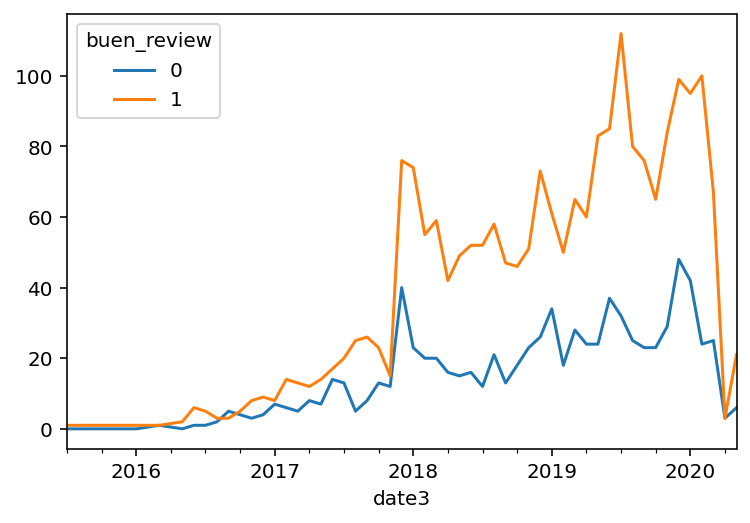

In [31]:
df_freq = numero_reviews.loc[ : ,[0,1] ] #.cumsum();
plt.figure();
df_freq.plot();

<Figure size 432x288 with 0 Axes>

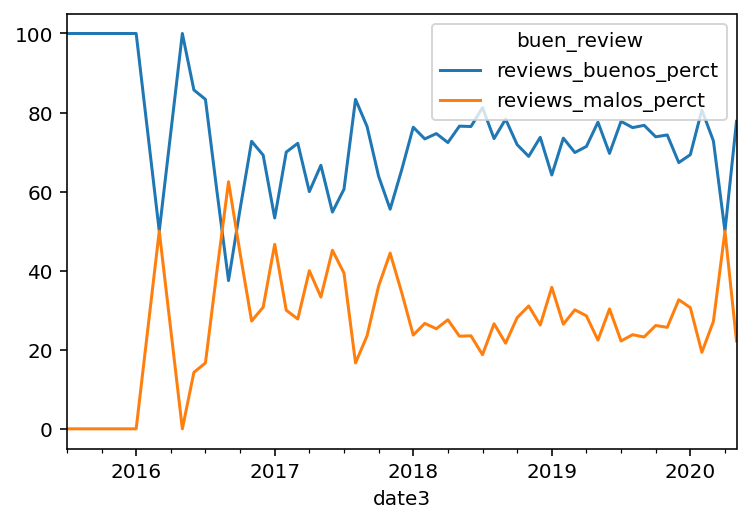

In [34]:
df_freq = numero_reviews.loc[ : ,["reviews_buenos_perct","reviews_malos_perct"] ] #.cumsum();
plt.figure();
df_freq.plot();

In [35]:
numero_reviews.head().style

buen_review,0,1,total_reviews,reviews_buenos_perct,reviews_malos_perct
date3,,,,,
2015-07,0.000000,1.000000,1.000000,100.000000,0.000000
2016-01,0.000000,1.000000,1.000000,100.000000,0.000000
2016-03,1.000000,1.000000,2.000000,50.000000,50.000000
2016-05,0.000000,2.000000,2.000000,100.000000,0.000000
2016-06,1.000000,6.000000,7.000000,85.714286,14.285714


In [32]:
#Genera un csv
#numero_reviews.to_csv("numero_reviews.csv")

In [37]:
df_com.loc[df_com['date3']=='2012-09', ['date3','buen_review']]

,date3,buen_review


In [38]:
df_imprime=df_com.loc[: , ["ID", "Estrellas", "buen_review", "date3", "Comentario" ] ]
comment=[convert_emojis(replaceAccents(x.lower().replace("\n", " "))) for x in df_imprime['Comentario'].astype(str)]
comment=limpia_translate(comment)
df_imprime["Comentario2"]=comment
#df_imprime.to_csv("Comentarios.csv")

In [39]:
df_imprime.head().style

,ID,Estrellas,buen_review,date3,Comentario,Comentario2
3,1256,5,1,2020-05,"Gran variedad de productos, excelente servicio (Translated by Google) Wide variety of products, excellent service","gran variedad de productos, excelente servicio"
4,1256,5,1,2020-05,Por es rápido y eficiente el servicio (Translated by Google) Because the service is fast and efficient,por es rapido y eficiente el servicio
11,1256,3,0,2020-03,"La tienda en si tiene una variedad de artículos, tal vez no tanto como para todos los gustos por el tamaño supongo pero si tiene diferentes opciones para los gustos de la gente, lo malo es que no tiene un amplio estacionamiento, y los únicos 4 o 5 cajones que tiene no son bien aprovechados ya que las motos ocupan los espacios si tener un orden y se estacionan como sea, los moto taxis por otro lado ocupan y tapan las entradas a estos mismos cajones de estacionamiento y por ende no permiten la entra y salida libre de vehículos y motos, por lo que ha tener a concideración al momento de visitar la tienda. (Translated by Google) The store itself has a variety of items, perhaps not as much as for all tastes due to size, I suppose, but if it has different options for people's tastes, the bad thing is that it does not have a large parking lot, and the only 4 or 5 drawers that it has are not well used since motorcycles occupy the spaces without having an order and they are parked as they are, motorcycle taxis on the other hand occupy and cover the entrances to these same parking spaces and therefore do not allow entry and Free departure of vehicles and motorcycles, so you have to consider when visiting the store.","la tienda en si tiene una variedad de articulos, tal vez no tanto como para todos los gustos por el tamano supongo pero si tiene diferentes opciones para los gustos de la gente, lo malo es que no tiene un amplio estacionamiento, y los unicos 4 o 5 cajones que tiene no son bien aprovechados ya que las motos ocupan los espacios si tener un orden y se estacionan como sea, los moto taxis por otro lado ocupan y tapan las entradas a estos mismos cajones de estacionamiento y por ende no permiten la entra y salida libre de vehiculos y motos, por lo que ha tener a concideracion al momento de visitar la tienda."
17,1256,5,1,2020-02,Por qué el servicio que brindan es eficiente y buen trato. (Translated by Google) Why the service they provide is efficient and good treatment.,por que el servicio que brindan es eficiente y buen trato.
23,1256,5,1,2020-02,Mejora tu vida (Translated by Google) Make your life better,mejora tu vida


## Se dividen los malos **etiquetados con 0**

In [38]:
df_com2=df_com.loc[df_com['buen_review'] == 1,]
df_com2=df_com2.loc[df_com2['date3']>='2018-01',]
split_2b=[convert_emojis(replaceAccents(x.lower().replace("\n", " "))) for x in df_com2['Comentario'].astype(str)]
del df_com2

pd.DataFrame(split_2b).head()

,0
0,"gran variedad de productos, excelente servicio (translated by google) wide variety of products, excellent service"
1,por es rapido y eficiente el servicio (translated by google) because the service is fast and efficient
2,por que el servicio que brindan es eficiente y buen trato. (translated by google) why the service they provide is efficient and good treatment.
3,mejora tu vida (translated by google) make your life better
4,tiene productos a buen precio (translated by google) it has products at a good price


In [40]:
split_2b=limpia_translate(split_2b)
split_2b[186:188]

['entre por un par de zapatos y sali con 2 pares aproveche descuento de contado',
 'muy bonitos recuerdos']

In [41]:
listCounts = []
big_list = list_to_words(split_2b)
#big_list = [word.decode('utf8', ) for word in big_list]
listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('palabras_exp_cliente1.csv')

In [43]:
listCounts

     12005
e     9590
a     7662
o     5719
n     5270
     ...  
C        1
7        1
%        1
5        1
6        1
Length: 62, dtype: int64

In [44]:
df_com2=df_com.loc[df_com['buen_review'] == 1, ['ID','Estrellas','date3','Comentario']]
df_com2=df_com2.loc[df_com2['date3']>='2018-01',]
indice=range(0,len(split_2b))
df_com2['indice']=indice
df_com2.set_index('indice')
df_com2['Procesamiento']=split_2b
df_com2.head()

,ID,Estrellas,date3,Comentario,indice,Procesamiento
3,1256,5,2020-05,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",0,"gran variedad de productos, excelente servicio"
4,1256,5,2020-05,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,1,por es rapido y eficiente el servicio
17,1256,5,2020-02,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,2,por que el servicio que brindan es eficiente y buen trato.
23,1256,5,2020-02,Mejora tu vida\n\n(Translated by Google)\nMake your life better,3,mejora tu vida
24,1256,4,2020-02,Tiene productos a buen precio\n\n(Translated by Google)\nIt has products at a good price,4,tiene productos a buen precio


In [46]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [47]:
## limpia comentarios
split_2b=clean_com(split_2b)
split_2b[10:15]

[['buen', 'surtido', 'facilidades', 'pago'],
 ['precios', 'accesibles', 'buen', 'trato', 'personal'],
 ['no', 'cuenta', 'articulos', 'muestra', 'pagina'],
 ['siempre',
  'ayudan',
  'necesito',
  'dan',
  'exelente',
  'atencion',
  'parte',
  'vendedores'],
 ['atencion', 'super', 'bien']]

In [48]:
## quita comas entre palabras
for i in range(0,len(split_2b)):
    split_2b[i]=comas2(split_2b[i])

split_2b[1:2]

[['es', 'rapido', 'eficiente', 'servicio']]

In [49]:
list_aux=[]
for x in split_2b:
    list_aux.append(list_to_str(x))

df_com2['Procesamiento2']=list_aux
df_com2.head()

,ID,Estrellas,date3,Comentario,indice,Procesamiento,Procesamiento2
3,1256,5,2020-05,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",0,"gran variedad de productos, excelente servicio",gran variedad productos excelente servicio
4,1256,5,2020-05,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,1,por es rapido y eficiente el servicio,es rapido eficiente servicio
17,1256,5,2020-02,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,2,por que el servicio que brindan es eficiente y buen trato.,servicio brindan es eficiente buen trato
23,1256,5,2020-02,Mejora tu vida\n\n(Translated by Google)\nMake your life better,3,mejora tu vida,mejora vida
24,1256,4,2020-02,Tiene productos a buen precio\n\n(Translated by Google)\nIt has products at a good price,4,tiene productos a buen precio,tiene productos buen precio


In [50]:
#quita palabras juntas
for i in range(0,len(split_2b)):
    split_2b[i]=split_words(split_2b[i], lista_separa)
    
split_2b[43618:43620]

[]

In [51]:
list_aux=[]
for x in split_2b:
    list_aux.append(list_to_str(x))

df_com2['Procesamiento3']=list_aux
df_com2.head()

,ID,Estrellas,date3,Comentario,indice,Procesamiento,Procesamiento2,Procesamiento3
3,1256,5,2020-05,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",0,"gran variedad de productos, excelente servicio",gran variedad productos excelente servicio,gran variedad productos excelente servicio
4,1256,5,2020-05,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,1,por es rapido y eficiente el servicio,es rapido eficiente servicio,es rapido eficiente servicio
17,1256,5,2020-02,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,2,por que el servicio que brindan es eficiente y buen trato.,servicio brindan es eficiente buen trato,servicio brindan es eficiente buen trato
23,1256,5,2020-02,Mejora tu vida\n\n(Translated by Google)\nMake your life better,3,mejora tu vida,mejora vida,mejora vida
24,1256,4,2020-02,Tiene productos a buen precio\n\n(Translated by Google)\nIt has products at a good price,4,tiene productos a buen precio,tiene productos buen precio,tiene productos buen precio


In [52]:
listCounts = []
big_list = list_to_words(split_2b)
#big_list = [word.decode('utf8', ) for word in big_list]
listCounts = pd.Series(big_list).value_counts()
listCounts.to_csv('palabras_exp_cliente2.csv')

In [53]:
## reemplaza verbos
split_com=[]
j=0
for i in range(0,len(split_2b)):
    try:
        split_com.append(word_tokenize(replaceVerbs(re.sub(' +', ' ',list_to_str(split_2b[i])))))
    except:
        split_com.append(split_2b[i])
        print("expected string or bytes-like object","=>", i,"=>", j)
        j=j+1
    

expected string or bytes-like object => 3 => 0
expected string or bytes-like object => 20 => 1
expected string or bytes-like object => 27 => 2
expected string or bytes-like object => 47 => 3
expected string or bytes-like object => 130 => 4
expected string or bytes-like object => 158 => 5
expected string or bytes-like object => 177 => 6
expected string or bytes-like object => 215 => 7
expected string or bytes-like object => 274 => 8
expected string or bytes-like object => 316 => 9
expected string or bytes-like object => 317 => 10
expected string or bytes-like object => 336 => 11
expected string or bytes-like object => 352 => 12
expected string or bytes-like object => 371 => 13
expected string or bytes-like object => 375 => 14
expected string or bytes-like object => 379 => 15
expected string or bytes-like object => 402 => 16
expected string or bytes-like object => 534 => 17
expected string or bytes-like object => 551 => 18
expected string or bytes-like object => 566 => 19
expected string

In [54]:
list_aux=[]
for x in split_com:
    list_aux.append(list_to_str(x))

df_com2['Procesamiento4']=split_com
df_com2.head()

,ID,Estrellas,date3,Comentario,indice,Procesamiento,Procesamiento2,Procesamiento3,Procesamiento4
3,1256,5,2020-05,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",0,"gran variedad de productos, excelente servicio",gran variedad productos excelente servicio,gran variedad productos excelente servicio,"[gran, variedad, productos, excelente, servicio]"
4,1256,5,2020-05,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,1,por es rapido y eficiente el servicio,es rapido eficiente servicio,es rapido eficiente servicio,"[ser, rapido, eficiente, servicio]"
17,1256,5,2020-02,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,2,por que el servicio que brindan es eficiente y buen trato.,servicio brindan es eficiente buen trato,servicio brindan es eficiente buen trato,"[servicio, brindan, ser, eficiente, buen, trato]"
23,1256,5,2020-02,Mejora tu vida\n\n(Translated by Google)\nMake your life better,3,mejora tu vida,mejora vida,mejora vida,"[mejora, vida]"
24,1256,4,2020-02,Tiene productos a buen precio\n\n(Translated by Google)\nIt has products at a good price,4,tiene productos a buen precio,tiene productos buen precio,tiene productos buen precio,"[tener, productos, buen, precio]"


In [56]:
nltk.download('stopwords')
stop2=stopwords.words('spanish')
stop2.extend(['tener','ser','estar','nada','todo','todos'])

stop2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [57]:
## dictionario creado
for i in range(0,len(split_com)):
    split_com[i]=[replace_palabras(word) for word in split_com[i] if word not in stop2]

split_com[10]

['buen', 'surtido', 'facilidades', 'pago']

In [58]:
list_aux=[]
for x in split_com:
    list_aux.append(list_to_str(x))

df_com2['Procesamiento5']=split_com
df_com2.head()

,ID,Estrellas,date3,Comentario,indice,Procesamiento,Procesamiento2,Procesamiento3,Procesamiento4,Procesamiento5
3,1256,5,2020-05,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",0,"gran variedad de productos, excelente servicio",gran variedad productos excelente servicio,gran variedad productos excelente servicio,"[gran, variedad, productos, excelente, servicio]","[gran, variedad, articulo, excelente, servicio]"
4,1256,5,2020-05,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,1,por es rapido y eficiente el servicio,es rapido eficiente servicio,es rapido eficiente servicio,"[ser, rapido, eficiente, servicio]","[rapido, eficiente, servicio]"
17,1256,5,2020-02,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,2,por que el servicio que brindan es eficiente y buen trato.,servicio brindan es eficiente buen trato,servicio brindan es eficiente buen trato,"[servicio, brindan, ser, eficiente, buen, trato]","[servicio, brindan, eficiente, buen, trato]"
23,1256,5,2020-02,Mejora tu vida\n\n(Translated by Google)\nMake your life better,3,mejora tu vida,mejora vida,mejora vida,"[mejora, vida]","[mejora, vida]"
24,1256,4,2020-02,Tiene productos a buen precio\n\n(Translated by Google)\nIt has products at a good price,4,tiene productos a buen precio,tiene productos buen precio,tiene productos buen precio,"[tener, productos, buen, precio]","[articulo, buen, precio]"


In [59]:
listCounts = []
big_list = list_to_words(split_2b)
#big_list = [word.decode('utf8', ) for word in big_list]
listCounts = pd.Series(big_list).value_counts()
listCounts.to_csv('palabras_exp_cliente3.csv')

In [60]:
## segundo stop
for i in range(0,len(split_com)):
    split_com[i]=[word for word in split_com[i] if word not in stop2 and len(word)>1]
    
split_com[10]

['buen', 'surtido', 'facilidades', 'pago']

In [63]:
listCounts = []
big_list = list_to_words(split_2b)
#big_list = [word.decode('utf8', ) for word in big_list]
listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('palabras_exp_cliente3.csv')

In [62]:
df_com2.loc[df_com2['indice']== 1,]

SyntaxError: ignored

In [64]:
prueba2=busca_en_lista(split_com, "dos")

In [65]:
## lematiza
split_com3=lematiza_lista(split_com)

In [66]:
list_aux=[]
for x in split_com3:
    list_aux.append(list_to_str(x))
    
df_com2['Procesamiento6']=list_aux
df_com2.head()

,ID,Estrellas,date3,Comentario,indice,Procesamiento,Procesamiento2,Procesamiento3,Procesamiento4,Procesamiento5,Procesamiento6
3,1256,5,2020-05,"Gran variedad de productos, excelente servicio\n\n(Translated by Google)\nWide variety of products, excellent service",0,"gran variedad de productos, excelente servicio",gran variedad productos excelente servicio,gran variedad productos excelente servicio,"[gran, variedad, productos, excelente, servicio]","[gran, variedad, articulo, excelente, servicio]",gran variedad articulo excelente servicio
4,1256,5,2020-05,Por es rápido y eficiente el servicio\n\n(Translated by Google)\nBecause the service is fast and efficient,1,por es rapido y eficiente el servicio,es rapido eficiente servicio,es rapido eficiente servicio,"[ser, rapido, eficiente, servicio]","[rapido, eficiente, servicio]",rapido eficiente servicio
17,1256,5,2020-02,Por qué el servicio que brindan es eficiente y buen trato.\n\n(Translated by Google)\nWhy the service they provide is efficient and good treatment.,2,por que el servicio que brindan es eficiente y buen trato.,servicio brindan es eficiente buen trato,servicio brindan es eficiente buen trato,"[servicio, brindan, ser, eficiente, buen, trato]","[servicio, brindan, eficiente, buen, trato]",servicio brindar eficiente bueno tratar
23,1256,5,2020-02,Mejora tu vida\n\n(Translated by Google)\nMake your life better,3,mejora tu vida,mejora vida,mejora vida,"[mejora, vida]","[mejora, vida]",mejorar vida
24,1256,4,2020-02,Tiene productos a buen precio\n\n(Translated by Google)\nIt has products at a good price,4,tiene productos a buen precio,tiene productos buen precio,tiene productos buen precio,"[tener, productos, buen, precio]","[articulo, buen, precio]",articulo bueno preciar


In [67]:
listCounts = []
big_list = list_to_words(split_com3)
#big_list = [word.decode('utf8', ) for word in big_list]
listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('palabras_exp_cliente6.csv')

In [ ]:
listCounts

In [ ]:
## corrige texto
#for x in range(0,len(split_com3)):
#    for word in range(0,len(split_com3[x])):
#        split_com3[x][word]=correct_text(split_com3[x][word])

#split_com3[10:13]

In [ ]:
#listCounts = []
#big_list = list_to_words(split_com3)
##big_list = [word.decode('utf8', ) for word in big_list]
#listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('palabras_exp_cliente5.csv')

## Paralelizacion

In [68]:
num_partitions = 80 #number of partitions to split dataframe
num_cores = 80 #number of cores on your machine

In [69]:
#funcion que paraleliza
#necesita una serie de pandas para poder concatenar
#resultado regresa una serie pandas
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

#funcion a paralelizar
## corrige texto
def corrige_texto(lista):
    list_aux=lista
    for x in range(0,len(list_aux)):
        for word in range(0,len(list_aux[x])):
            list_aux[x][word]=correct_text(list_aux[x][word])
    return pd.Series(list_aux)


In [ ]:
start=time.time()
split_corrige=parallelize_dataframe(split_com3, corrige_texto)
end=time.time()
# total time taken
print(f"Runtime of the program is {end - start}")
split_corrige[0:3]

In [ ]:
list_aux=[]
for x in split_corrige:
    list_aux.append(list_to_str(x))
    
df_com2['Procesamiento7']=list_aux
df_com2.head()

In [ ]:
listCounts = []
big_list = list_to_words(split_corrige)
#big_list = [word.decode('utf8', ) for word in big_list]
listCounts = pd.Series(big_list).value_counts()
listCounts.to_csv('palabras_exp_cliente7.csv')

In [ ]:
df_com2.loc[df_com2['indice']==91,]

In [ ]:
### lista para comenzar el procesamiento del modelo
list_aux=[]
for x in split_corrige:
    list_aux.append(x)

list_aux[0:3]

In [ ]:
#Ya tenemos la matriz de documentos lista para trabajarse
# list_aux contiene texto limpio y lematizacion
comentarios=pd.Series([list_aux.index])
for x in range(0,len(list_aux)):
    comentarios[x]=list_to_str(list_aux[x])

comentarios[0:2]

## Modelos

In [ ]:
# librerias
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

#Preparmos la información dandole un peso a cada palabra mediante su frecuencia de aparición
# prepare NMF is able to use tf-idf
#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(comentarios)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
no_topics = 3
# Run NMF
#Factorización matricial no negativa
#Técnica de reducción de la dimensionalidad
#Reconstruye la muestra  factorización las matrices
#¿El número de tópicos quien lo define?
#¿Cuando las oaciones ya son un vector númerico como determino la relación entre vectores?
nmf_3 = NMF(n_components=no_topics, solver='cd', max_iter=500, 
            random_state=1, alpha=.1, l1_ratio=.85, init='nndsvd').fit(tfidf)

## palabras y doc con pesos más representativas
nmf_W3 = nmf_3.transform(tfidf)
nmf_H3 = nmf_3.components_

display_topics(nmf_H3, nmf_W3, feature_names=tfidf_feature_names, documents=split_2b, 
               no_top_words=10, no_top_documents=6)



Topic 0:
bueno atencion lugar ser servicio no surtir articulo precisar falto
['bueno', 'atencion', 'buena']
['buena', 'buena', 'atencion']
['bueno']
['bueno']
['buena']
['buen', 'os']
Topic 1:
malo servicio atencion no cliente personas ser atender emplear lento
['pesimo', 'servicio', 'pesimo']
['mal', 'servicio', 'pesimo']
['pesimo', 'mal', 'servicio']
['mal', 'mal', 'servicio']
['pesimo', 'servicio', 'pesimo']
['mal', 'servicio', 'pesimo']
Topic 2:
bien no atender ser todo surtir tener tienda variedad falto
['bien']
['bien']
['bien']
['bien']
['bien']
['bien']


In [ ]:
#pd.DataFrame(nmf_W3, columns=['T1', 'T2', 'T3']).to_csv("Malos_NMF_C3.csv")

top_terms=10
TOTAL_TOPICS=3
vocabulary=np.array(tfidf_feature_names)

topic_key_term_idxs = np.argsort(-np.absolute(nmf_H3), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

,Terms per Topic
Topic1,"bueno, atencion, lugar, ser, servicio, no, surtir, articulo, precisar, falto"
Topic2,"malo, servicio, atencion, no, cliente, personas, ser, atender, emplear, lento"
Topic3,"bien, no, atender, ser, todo, surtir, tener, tienda, variedad, falto"


In [ ]:
no_topics = 4
# Run NMF
nmf_4 = NMF(n_components=no_topics, solver='cd', max_iter=500, 
            random_state=1, alpha=.1, l1_ratio=.85, init='nndsvd').fit(tfidf)

## palabras y doc con pesos más representativas
nmf_W4 = nmf_4.transform(tfidf)
nmf_H4 = nmf_4.components_

display_topics(nmf_H4, nmf_W4, feature_names=tfidf_feature_names, documents=split_2b, 
               no_top_words=10, no_top_documents=6)


Topic 0:
bueno atencion lugar servicio precisar surtir comprar ubicacion cliente ser
['buena', 'buena', 'atencion']
['bueno', 'atencion', 'buena']
['buena']
['buena']
['bueno']
['bueno']
Topic 1:
malo servicio atencion cliente personas emplear lento cajero partir atender
['pesimo', 'servicio', 'pesimo']
['pesimo', 'pesimo', 'servicio']
['pesimo', 'mal', 'servicio']
['mal', 'mal', 'servicio']
['mal', 'pesimo', 'servicio']
['mal', 'servicio', 'pesimo']
Topic 2:
bien atender surtir todo ubicar tienda solo general lugar estar
['bien']
['bien']
['bien']
['bien']
['bien']
['bien']
Topic 3:
no ser tener variedad falto articulo personas atender todo tienda
['no', 'es']
['no', 'es', 'grande', 'no', 'tiene', 'mucha', 'variedad']
['no', 'es', 'surtido', 'no', 'secadora']
['es', 'pequeno', 'no', 'tiene', 'variedad']
['no', 'variedad', 'ni', 'productos']
['lugar', 'es', 'pequeno', 'variedad', 'productos', 'no', 'es', 'mucha']


In [ ]:
#pd.DataFrame(nmf_W4, columns=['T1', 'T2', 'T3','T4']).to_csv("Malos_NMF_C4.csv")

top_terms=10
TOTAL_TOPICS=4
vocabulary=np.array(tfidf_feature_names)

topic_key_term_idxs = np.argsort(-np.absolute(nmf_H4), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

,Terms per Topic
Topic1,"bueno, atencion, lugar, servicio, precisar, surtir, comprar, ubicacion, cliente, ser"
Topic2,"malo, servicio, atencion, cliente, personas, emplear, lento, cajero, partir, atender"
Topic3,"bien, atender, surtir, todo, ubicar, tienda, solo, general, lugar, estar"
Topic4,"no, ser, tener, variedad, falto, articulo, personas, atender, todo, tienda"


In [ ]:
no_topics = 5
# Run NMF
nmf_5 = NMF(n_components=no_topics, solver='cd', max_iter=500, 
            random_state=1, alpha=.1, l1_ratio=.85, init='nndsvd').fit(tfidf)


## palabras y doc con pesos más representativas
nmf_W5 = nmf_5.transform(tfidf)
nmf_H5 = nmf_5.components_

display_topics(nmf_H5, nmf_W5, feature_names=tfidf_feature_names, documents=split_2b, 
               no_top_words=10, no_top_documents=6)


Topic 0:
servicio bueno rapido cliente amable atento banco dar gran malo
['ecelenente', 'servicio']
['servicio']
['servicio']
['servicio']
['servicio', 'tratato']
['x', 'servisio']
Topic 1:
excelente lugar tienda tratar comprar ubicacion variedad articulo personas surtir
['excelente']
['excelente']
['excelente']
['excelente']
['exelente']
['excelente']
Topic 2:
bien atender surtir tienda amable ubicar personas rapido encontrar super
['bien']
['bien']
['bien']
['bien']
['bien']
['bien']
Topic 3:
atencion bueno cliente rapido personas amable partir emplear falto gastar
['atencion']
['atencion']
['atencion']
['atencion']
['atencion']
['atencion']
Topic 4:
bueno lugar surtir comprar precisar articulo tienda variedad tratar ubicacion
['fue', 'buena']
['bueno']
['bueno']
['buena']
['bueno']
['bueno']


In [ ]:
#pd.DataFrame(nmf_W5, columns=['T1', 'T2', 'T3','T4','T5']).to_csv("Malos_NMF_C5.csv")

top_terms=10
TOTAL_TOPICS=5

vocabulary=np.array(tfidf_feature_names)

topic_key_term_idxs = np.argsort(-np.absolute(nmf_H5), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df


,Terms per Topic
Topic1,"servicio, bueno, rapido, cliente, amable, atento, banco, dar, gran, malo"
Topic2,"excelente, lugar, tienda, tratar, comprar, ubicacion, variedad, articulo, personas, surtir"
Topic3,"bien, atender, surtir, tienda, amable, ubicar, personas, rapido, encontrar, super"
Topic4,"atencion, bueno, cliente, rapido, personas, amable, partir, emplear, falto, gastar"
Topic5,"bueno, lugar, surtir, comprar, precisar, articulo, tienda, variedad, tratar, ubicacion"


In [ ]:
topics_frame=pd.DataFrame(nmf_W5, columns=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_frame['max_topics']=topics_frame.idxmax(axis=1)
topics_frame.index=df_com2.index
df_com2_impr=df_com2.loc[:,['ID','date3','Estrellas','Procesamiento', 'Procesamiento3','Procesamiento5','Procesamiento7']]
df_com2_impr=pd.concat([df_com2_impr, topics_frame], axis=1)
df_com2_impr.to_csv("Topic5_buenos.csv")


In [ ]:
no_topics = 8
# Run NMF
nmf_3 = NMF(n_components=no_topics, solver='cd', max_iter=500, 
            random_state=1, alpha=.1, l1_ratio=.85, init='nndsvd').fit(tfidf)

## palabras y doc con pesos más representativas
nmf_W3 = nmf_3.transform(tfidf)
nmf_H3 = nmf_3.components_

display_topics(nmf_H3, nmf_W3, feature_names=tfidf_feature_names, documents=split_2b, 
               no_top_words=10, no_top_documents=6)

Topic 0:
malo servicio emplear cajero tratar partir actitud lento banco gerente
['pesimo', 'servicio']
['pesimo', 'servicio']
['mal', 'servicio']
['pesimo', 'servicio']
['pesimo', 'servicio']
['mal', 'servicios']
Topic 1:
bueno servicio precisar surtir tienda ubicacion articulo tratar ofertar atencion
['bueno']
['buena', 'minitienda']
['bueno']
['bueno']
['bueno']
['bueno']
Topic 2:
bien surtir atender todo ubicar general tienda estacionamiento solo servicio
['bien']
['bien']
['bien']
['bien']
['bien']
['bien']
Topic 3:
atencion malo cliente personas falto regular partir emplear poco mejorar
['atencion', 'x']
['atencion']
['malanaten', 'atencion']
['no', 'mucha', 'atencion']
['atencion']
['atencion']
Topic 4:
variedad falto articulo surtir poco ropa estacionamiento pequeno zapato gran
['falta', 'variedad', 'productos']
['falta', 'variedad', 'productos']
['falta', 'variedad', 'productos']
['faltan', 'variedad', 'articulos']
['falta', 'variedad', 'productos']
['falta', 'variedad', 'produ

In [ ]:
#pd.DataFrame(nmf_W3, columns=['T1', 'T2', 'T3']).to_csv("Malos_NMF_C3.csv")

top_terms=10
TOTAL_TOPICS=8
vocabulary=np.array(tfidf_feature_names)

topic_key_term_idxs = np.argsort(-np.absolute(nmf_H3), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_frame=pd.DataFrame(nmf_W3, columns=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df

,Terms per Topic
Topic1,"malo, servicio, emplear, cajero, tratar, partir, actitud, lento, banco, gerente"
Topic2,"bueno, servicio, precisar, surtir, tienda, ubicacion, articulo, tratar, ofertar, atencion"
Topic3,"bien, surtir, atender, todo, ubicar, general, tienda, estacionamiento, solo, servicio"
Topic4,"atencion, malo, cliente, personas, falto, regular, partir, emplear, poco, mejorar"
Topic5,"variedad, falto, articulo, surtir, poco, ropa, estacionamiento, pequeno, zapato, gran"
Topic6,"lugar, comprar, pequeno, estacionamiento, excelente, agradable, ir, hacer, bueno, estacionarse"
Topic7,"atender, personas, tardar, caja, todo, lento, solo, tienda, hacer, gente"
Topic8,"caro, todo, precisar, credito, calidad, articulo, cosa, tienda, encontrar, coppel"


In [ ]:
topics_frame=pd.DataFrame(nmf_W3, columns=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_frame['max_topics']=topics_frame.idxmax(axis=1)
topics_frame.index=df_com2.index
df_com2_impr=df_com2.loc[:,['ID','date3','Estrellas','Procesamiento', 'Procesamiento3','Procesamiento5','Procesamiento7']]
df_com2_impr=pd.concat([df_com2_impr, topics_frame], axis=1)
df_com2_impr.to_csv("Topic8v2m.csv")


In [ ]:
# LDA
# get bag of words features in sparse format
cv = CountVectorizer(ngram_range=(1,1), min_df=0., max_df=1. )
# cv_matrix
cv_matrix = cv.fit_transform(comentarios)
# view dense representation
# warning might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,_cloned_eyes,_cold_sweet,_linking_eye,_mining_eyes,aa,aaas,aaron,abandonar,abanico,abaratar,...,zihatanejo,zihuatanejo,zimatlan,zinacantepec,zinser,zona,zukulemtas,zumpango,zuz,zuzul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#LDA

#learning_method='online', learning_offset=50.
lda_model_3 = LatentDirichletAllocation(n_components=3, max_iter=1000, 
                            learning_method='online', learning_offset=50.,random_state=0).fit(cv_matrix)
lda_W3 = lda_model_3.transform(cv_matrix)
lda_H3 = lda_model_3.components_

display_topics(lda_H3, lda_W3, feature_names=vocab, documents=split_2b, 
               no_top_words=10, no_top_documents=6)

Topic 0:
bueno ser no articulo lugar falto tener tienda atencion variedad
['buena', 'tienda', 'comprar', 'credito', 'contado', 'es', 'facil', 'aprueben', 'credito', 'encuentras', 'gran', 'mayoria', 'cosas', 'busques', 'ropa', 'zapatos', 'electronica', 'joyeria', 'perfumes', 'herramientas', 'muebles', 'celulares', 'incluso', 'motocicletas', 'accesorios']
['encuentras', 'mucha', 'variedad', 'mercancias', 'ropa', 'zapatos', 'marca', 'electrodomesticos', 'muebles', 'blancos', 'perfumeria', 'fina', 'aunque', 'precios', 'productos', 'son', 'elevados', 'tiene', 'atractivas', 'ofertas', 'toda', 'tienda', 'productos', 'marca']
['no', 'soy', 'fan', 'hacer', 'compras', 'tiendas', 'departamentales', 'precios', 'loa', 'considero', 'elevados', 'credito', 'tiene', 'linea', 'electrodomesticos', 'buena', 'variedad', 'ropa', 'bastante', 'considerable', 'recomendacion', 'compren', 'contado', 'eviten', 'creditos']
['tuve', 'cruzar', 'toda', 'ciudad', 'era', 'unica', 'tienda', 'contaba', 'articulo', 'busca

In [ ]:
## guarda resultados
features = pd.DataFrame(lda_W3, columns=['T1', 'T2', 'T3'])
#features.to_csv("Malos_C3.csv")

top_terms=10
TOTAL_TOPICS=3
vocabulary=np.array(cv.get_feature_names())
topic_key_term_idxs = np.argsort(-np.absolute(lda_H3), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

,Terms per Topic
Topic1,"bueno, ser, no, articulo, lugar, falto, tener, tienda, atencion, variedad"
Topic2,"bien, pagar, caja, gente, tardar, lento, siempre, fila, solo, cajero"
Topic3,"no, malo, servicio, ser, personas, ir, atender, atencion, tener, estar"


In [ ]:
for topic_weights in lda_H3:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()

[('bueno', 8665.05622039274), ('ser', 6613.971536230915), ('no', 4639.674946465217), ('articulo', 3768.958681353029), ('lugar', 3630.43196303171), ('falto', 3516.096120422357), ('tener', 3480.001976298416), ('tienda', 3106.032025450171), ('atencion', 3011.8035794244056), ('variedad', 2839.709983185754), ('precisar', 2204.3541527308944), ('surtir', 2181.853295254713), ('todo', 2118.175668246173), ('estacionamiento', 2094.410410243998), ('ropa', 2023.774359861944), ('encontrar', 1775.3664819268079), ('coppel', 1557.3668916478048), ('comprar', 1476.339368841678), ('pequeno', 1423.3400048934927), ('cosa', 1183.9295319585456), ('zapato', 967.7604306182684), ('contar', 956.7584768378938), ('poco', 950.8922912745996), ('caro', 917.2949463930041), ('regular', 832.886645334484), ('credito', 717.2034565737482), ('calidad', 666.6696837607985), ('buscar', 665.0490214991157), ('mercancia', 652.7561159990469), ('solo', 649.9892786072216), ('excelente', 647.1030495244054), ('doblar', 642.587496784974

In [ ]:
#LDA
import time

# starting time
start = time.time()
lda_model_4 = LatentDirichletAllocation(n_components=4, max_iter=1000, 
                            learning_method='online', learning_offset=50.,random_state=0).fit(cv_matrix)
lda_W4 = lda_model_4.transform(cv_matrix)
lda_H4 = lda_model_4.components_


display_topics(lda_H4, lda_W4, feature_names=vocab, documents=split_2b, 
               no_top_words=10, no_top_documents=6)

end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")

Topic 0:
ser bueno no articulo lugar tener tienda variedad precisar surtir
['encuentras', 'mucha', 'variedad', 'mercancias', 'ropa', 'zapatos', 'marca', 'electrodomesticos', 'muebles', 'blancos', 'perfumeria', 'fina', 'aunque', 'precios', 'productos', 'son', 'elevados', 'tiene', 'atractivas', 'ofertas', 'toda', 'tienda', 'productos', 'marca']
['encuentras', 'ropa', 'todos', 'gustos', 'calzado', 'linea', 'blanca', 'electronica', 'muebles', 'telefonia', 'aparatos', 'electronicos', 'pantallas', 'planas', 'diferentes', 'tamanos', 'precios', 'marcas']
['es', 'tienda', 'prestigio', 'encuentra', 'infinidad', 'articulos', 'ropa', 'calzado', 'varios', 'modelos', 'marcas', 'mejor', 'precio', 'es', 'tienda', 'gusta']
['es', 'caro', 'no', 'tiene', 'gran', 'calidad', 'productos', 'todo', 'tienen', 'consigue', 'facilmente', 'mejor', 'precio', 'mejor', 'calidad', 'tiendas']
['cuenta', 'multiples', 'productos', 'linea', 'blanca', 'ropa', 'zapatos', 'es', 'opcion', 'aunque', 'precios', 'no', 'siempre',

In [ ]:
## guarda resultados
features = pd.DataFrame(lda_W4, columns=['T1', 'T2', 'T3', 'T4'])
#features.to_csv("Malos_C4.csv")

top_terms=10
TOTAL_TOPICS=4
vocabulary=np.array(cv.get_feature_names())
topic_key_term_idxs = np.argsort(-np.absolute(lda_H4), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

,Terms per Topic
Topic1,"ser, bueno, no, articulo, lugar, tener, tienda, variedad, precisar, surtir"
Topic2,"bien, caja, cajero, tardar, lento, solo, fila, gente, pagar, abrir"
Topic3,"malo, servicio, atencion, personas, atender, ser, bueno, cliente, emplear, falto"
Topic4,"no, ser, ir, tener, hacer, estar, comprar, dar, poder, solo"


In [ ]:
for topic_weights in lda_H4:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()

[('ser', 6064.454852838021), ('bueno', 5467.465712603211), ('no', 3793.998779622621), ('articulo', 3768.9421969135706), ('lugar', 3630.407449232427), ('tener', 3190.6831308761866), ('tienda', 3041.9169802566653), ('variedad', 2839.6397825139798), ('precisar', 2204.2927984323314), ('surtir', 2181.792959985295), ('estacionamiento', 2094.3661748662994), ('ropa', 2023.7388354542957), ('todo', 1974.2664558610911), ('caro', 1858.330683621717), ('encontrar', 1775.321827556118), ('falto', 1681.3335980263055), ('coppel', 1632.6115137585464), ('pequeno', 1423.2797672220838), ('comprar', 959.3431372529518), ('zapato', 899.5651345550921), ('contar', 891.1410000265755), ('poco', 888.9669999079408), ('cerrar', 696.9167867548884), ('calidad', 666.6203254103125), ('doblar', 642.6039984062935), ('calzado', 620.17036603894), ('grande', 604.9095954984264), ('gran', 593.1236151947912), ('credito', 571.4903732343204), ('mercancia', 554.6188225696174), ('sucursal', 533.3467081668667), ('cualquiera', 517.643

In [ ]:
#LDA
import time

# starting time
start = time.time()

lda_model_5 = LatentDirichletAllocation(n_components=5, max_iter=1000, 
                            learning_method='online', learning_offset=50.,random_state=0).fit(cv_matrix)
lda_W5 = lda_model_5.transform(cv_matrix)
lda_H5 = lda_model_5.components_

display_topics(lda_H5, lda_W5, feature_names=vocab, documents=split_2b, 
               no_top_words=10, no_top_documents=6)

end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")

Topic 0:
bien coppel atender gastar ir siempre solo grande tienda gente
['salir', 'coppel', 'percatamos', 'comedor', 'soriana', 'echeverria', 'obviamente', 'fuimos', 'comer', 'mariscos', 'amburguesas', 'pizza']
['soriana', 'ponen', 'chocantes', 'no', 'permiten', 'utilices', 'pelotas', 'no', 'venden', 'jugar', 'todo', 'bien']
['menos', 'qq', 'fui', 'ivan', 'dar', 'credito', 'qq', 'votan', 'changos']
['OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand']
['gusta', 'venir', 'tienda', 'debido', 'bien', 'organizada', 'bien', 'atendida']
['ocasiones', 'personas', 'atienden', 'tienen', 'mal', 'caracter', 'menos', 'aparentan', 'actitud']
Topic 1:
bueno lugar servicio comprar encontrar ropa rapido falto buscar articulo
['buen', 'lugar', 'adquirir', 'productos', 'linea', 'blanca', 'muebles', 'ropa', 'calzado', 'juguetes', 'electronicos']
['lugar', 'puedes', 'comprar', 'varios', 'articulos', 'electricos', 'ropa', 'calzado', 'accesorios', 'cocina', 'muebles']
['pu

In [ ]:
display_topics(lda_H5, lda_W5, feature_names=vocab, documents=split_2b, 
               no_top_words=10, no_top_documents=6)

Topic 0:
bien coppel atender gastar ir siempre solo grande tienda gente
['salir', 'coppel', 'percatamos', 'comedor', 'soriana', 'echeverria', 'obviamente', 'fuimos', 'comer', 'mariscos', 'amburguesas', 'pizza']
['soriana', 'ponen', 'chocantes', 'no', 'permiten', 'utilices', 'pelotas', 'no', 'venden', 'jugar', 'todo', 'bien']
['menos', 'qq', 'fui', 'ivan', 'dar', 'credito', 'qq', 'votan', 'changos']
['OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand', 'OK_hand']
['gusta', 'venir', 'tienda', 'debido', 'bien', 'organizada', 'bien', 'atendida']
['ocasiones', 'personas', 'atienden', 'tienen', 'mal', 'caracter', 'menos', 'aparentan', 'actitud']
Topic 1:
bueno lugar servicio comprar encontrar ropa rapido falto buscar articulo
['buen', 'lugar', 'adquirir', 'productos', 'linea', 'blanca', 'muebles', 'ropa', 'calzado', 'juguetes', 'electronicos']
['lugar', 'puedes', 'comprar', 'varios', 'articulos', 'electricos', 'ropa', 'calzado', 'accesorios', 'cocina', 'muebles']
['pu

In [ ]:
## guarda resultados
#features.to_csv("Malos_C5.csv")

top_terms=10
TOTAL_TOPICS=5
vocabulary=np.array(cv.get_feature_names())
topic_key_term_idxs = np.argsort(-np.absolute(lda_H5), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

,Terms per Topic
Topic1,"bien, coppel, atender, gastar, ir, siempre, solo, grande, tienda, gente"
Topic2,"bueno, lugar, servicio, comprar, encontrar, ropa, rapido, falto, buscar, articulo"
Topic3,"bueno, atencion, surtir, variedad, articulo, precisar, personas, amable, tienda, tratar"
Topic4,"caja, banco, pagar, tumbs_up, hacer, area, tardar, vez, fila, ayudar"
Topic5,"excelente, servicio, estacionamiento, tienda, cosa, ampliar, bonito, contar, bastante, encanta"


In [ ]:
for topic_weights in lda_H5:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()

[('bien', 13131.863234449118), ('coppel', 4476.430101382402), ('atender', 4385.855668916234), ('gastar', 3047.689513845546), ('ir', 2840.341934748802), ('siempre', 2793.769396172817), ('solo', 2612.9553426828857), ('grande', 2247.768982676852), ('tienda', 2139.9717147233796), ('gente', 2077.5668137817343), ('personas', 1767.7171531971524), ('amable', 1472.7495822711503), ('encontrar', 1407.7340599052773), ('limpiar', 1319.8915064772493), ('dar', 1236.4823597738962), ('malo', 1232.7187396303207), ('aunque', 1215.0699446988579), ('necesitar', 1139.8856776552507), ('haber', 982.9301707604437), ('poder', 940.6116690533764), ('instalacion', 773.0189391618261), ('general', 757.7493453752046), ('sucursal', 688.5891848780487), ('cualquiera', 678.9171481691066), ('deber', 667.9228657333434), ('querer', 631.2736245705258), ('visitar', 605.7157797467707), ('vender', 579.1410588816213), ('departamento', 556.0409178774294), ('lento', 495.37264975861007), ('nuevo', 484.564611891669), ('pasar', 484.0

In [ ]:
features = pd.DataFrame(lda_W5, columns=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
features['max_topics']=features.idxmax(axis=1)
features.index=df_com2.index
df_com2_impr=df_com2.loc[:,['ID','date3','Estrellas','Procesamiento', 'Procesamiento3','Procesamiento5','Procesamiento7']]
df_com2_impr=pd.concat([df_com2_impr, features], axis=1)
df_com2_impr.to_csv("Topic5_buenos.csv")


In [ ]:
features

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,0.025041,0.071091,0.024885,0.843067,0.002222,0.002222,0.024804,0.002222,0.002222,0.002222
1,0.774989,0.025000,0.025000,0.025002,0.025000,0.025000,0.025007,0.025001,0.025000,0.025000
2,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.849997,0.016667
3,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
4,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.611972,0.228027,0.020000,0.020001
...,...,...,...,...,...,...,...,...,...,...
48448,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000
48449,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.699999,0.033334,0.033333,0.033333
48450,0.008334,0.008334,0.008334,0.008334,0.008333,0.202195,0.233645,0.008334,0.175464,0.338692
48451,0.025000,0.025000,0.775000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
